
# Introduction

This annotated jupyter notebook is intended to provide training material for users of a system for seasonal hydrological forecast in the Shire River Basin - a climate service developed under funding from FOCUS Africa project. 

The notebook focuses on one of the processes involved in this sytem, namely the process of calibration of a probabilistic (an initial condition ensemble) seasonal forecast to the reference historical data.

While it is intended as a training material, it assumes that the "trainee", or a user of this notebook has a basic understanding of:
- seasonal forecasting concepts such as seasonal foreasting with dynamical models and in particular understanding of an initial condition ensemble forecast
- statistical concepts such as probability, distributions, quantiles etc.
- data processing using python


## Objectives of this notebook as a training resource

The objectives are fourfold:
<ol>
<li>
Illustrate a relatively complex data processing problem (calibration of seasonal forecast data towards input to a daily hydrological model)
<li>
Illustrate how to translate that problem into an algorithm
<li>
Illustrate how to implement the algorithm into python code utilizing xarray library
<li>
Illustrate good practices in organization of data and code
</ol>

## How to use this notebook?
As a training resource, this notebook is set up to work with the provided set of data. You need to download data and the notebook from github repo, put them in one directory, and unzip the data archive. This will create a data directory in your current directory. You can then start the notebook, and hopefully work though the training example. 

## Copyright/Licence
<i>not sure what to put here, but I guess some copyright statement should be used...</i>

## A bit of a background
Hydrological modelling for water resources in Malawi is done at Malawi DCCMS using a suite of three models:
- rainfall-runoff model of catchment upstream from Lake Malawi
- Lake Malawi water balance model
- rainfall-runoff and river routing model for the Lower Shire River basin.

The hydrological models were developed/calibrated with a bespoke gridded, daily rainfall and air temperature dataset that are a blend of CRU and observational data. This dataset covers only the historical period of 1981-2018. 

This hydrological modelling suite does not currently operate in a seasonal forecast mode, and thus there is scope for development and implementation of seasonal hydrological forecast where these three models are routinely run with forcing data from a seasonal climate forecast.

The overall framework of the seasonal forecasting system is briefly described below, but the intention of this notebook is to present the processing of climate forecast data from a probabilistic climate forecast generated by a dynamical global climate model to the format suitable for forcing of the DCCMS hydrological model suite.  


## Adopted approach to implementing the DCCMS hydrological models in seasonal forecasting mode 
Overall framework for the operational seasonal hydrological forecast in the Lake Malawi Basin is illustrated in Fig. 1. In that, the hydrological forecast is issued every month and covers 6 monthly period starting on that month.
<center>
<img src="./figures/forecast_fig1.png" alt="framework2" class="bg-primary mb-1" width="500px">

</center>

<center>
<i>Fig. 1 Timing of hydrological model simulations in the seasonal hydrological forecasting system</i>
</center>

The hydrological forecast is based on forecast climate variables generated by an ensemble of dynamical models. The entire ensemble can be processed, or alternatively only selected models. Since the models generate a probabilistic ensemble forecast, even using one model will involve multiple hydrological simulations. The system requires the following simulations with the suite of hydrological models (Fig. 2):
- Simulations to establish initial conditions for the forecast simulations. These simulations are based on a historical, observed time series of rainfall that spans from the beginning of record till the month prior to the date of issuing the forecast.
- Simulations forced by forecast data. These are multiple runs of each model forced by an ensemble of time series of climatic variables derived from the raw forecast data through a statistical calibration procedure.

Output of the hydrological simulations constitutes an ensemble of possible future hydrological states, and that is interpreted within a probabilistic framework - i.e. in terms of probabilities of exceedance etc.



<center>
<img src="./figures/forecast_fig2.png" alt="framework2" class="bg-primary mb-1" width="500px">
</center>
<center>
<i>Fig. 2 Schematic illustration of the outputs of the seasonal hydrological forecasting system</i>
</center>

## Datastream underlying the hydrological forecasting system

Fig. 3 illustrates the "flow" of data in the hydrological forecasting system. There are a number of steps involved:
- download of climate forecast data
- pre-processing (or homogeneization) of climate forecast data
- integration of monitoring/observational data with historical hydrological model forcing data
- downscaling and calibration of climate forecast data
- running of the three hydrological models with monitoring/observational data and seasonal forecast data

<b>This notebook describes only the process of forecast downscaling/calibration!</b>

<center>
<img src="./figures/forecast_fig3.png" alt="framework3" class="bg-primary mb-1" width="500px">
    
</center>
<center>
<i>Fig. 3 Datastream underlying the hydrological forecasting system</i>
</center>


# Process of forecast downscaling & calibration

<center>
<img src="./figures/forecast_fig4.png" alt="framework4" class="bg-primary mb-1" width="500px">

</center>
<center>
<i>Fig. 4 Forecast downcaling and calibration</i>
</center>

## Monthly data
Calibration of the monthly data using the IoV approach against observed monthly data (hydrological model input aggregated to monthly totals) (Johnson and Bowler, 2009).
The IoV approach is suited to ensure the condition of ensemble consistency (as described above, i.e. that the observations are statistically indistinguishable from a member of the forecast ensemble). That condition translates into two requirements 1) that the MSE of the ensemble mean is equal to climatological mean of ensemble variance (i.e. mean of variances of ensemble members of all forecasts of a given month at a given lead time), and 2) that climatological variance of an ensemble member is equal to the climatological variance of observations. This is achived by a set of linear transformation of the ensemble data as per Johnson and Bowler (2009). The calibration is implemented at each grid point, for each target month at each forecast lead time. 

## Daily data
Bias correction at daily time scale is carried out using a modified quantile-quantile mapping approach. The modification accounts for the requirement that daily bias-corrected data should yield monthly total corresponding to the calibrated monthly value. In order to achieve that - an iterative procedure of adjustment of quantiles is implemented (Fig. 5). This allows for achieving agreement between daily and monthly totals, and adherence of the daily data to the observational distribution. 

<center>
<img src="./figures/forecast_fig5.png" alt="framework5" class="bg-primary mb-1" width="500px">

</center>
<center>
<i>Fig. 5 Bias-correcting of daily data</i>
</center>



# Prerequisites for the process implemented in this notebook

We do not implement here the entire process of generation of the seasonal hydrological forecast as illustrated in Fig. 3. Rather, we focus only on the Downscaling/Calibration step.

In order to implement this step - a number of pre-requisites are needed, namely:
- raw forecast data have to be downloaded from the source
- the raw data have to be harmonized to be compatible with this script. This involves:
    - individual forecasts have to be stored in separate netcdf files
    - the netcdf data file has to have a particular structure:
        - forecast data are stored in a four-dimensional array, with the following dimensions order: time,member,latitude,longitude
        - variable names have to be harmonized - this script uses <i>latitude</i> and <i>longitude</i> for latitude and longitude, <i>time</i> for time variable, <i>pr</i> for precipitation and <i>member</i> for ensemble member variable
        - the time variable encodes date/time of the period for which forecast is issued. This is feasible only if data from an individual forecast, i.e. a forecast issued on a particular date, are stored in an individual file. The gain here is that we do not have to use/encode "lead time" variable, which is potentially rather confusing in the context of daily data.
    - forecast data have to be regrided to the same domain and spatial grid size as the observed reference data
    - directory structure and file naming convention has to be aligned with those adopted here (described below)
    - we consider that the forecast spans 6 months from the issuance date
    - for forecast - at least daily data have to be available. Monthly data are required, but they can be calculated from daily "on the fly", i.e. within this script, and do not have to be pre-calculated during harmonization
    

## Data model
The sample data provided with this notebook are created under a particular "data model", i.e. a schematic that governs the directory structure and file naming conventions adopted to store the data. 

That data model requires some explanation before we proceed.


### Directory structure:

The data are stored in the following tree of directories:

<i>\[data_dir\]/\[ensemble\]/\[model\]/\[basetime\]/\[domain\]/\[variable\]</i>



<b><i>data_dir</i></b>

This is the directory in which harmonized forecast data are stored. That directory is specific to the computer/file system on which the system operates. This allows easy adaptation of the code if the script is ported or set-up on a different PC, as well as setting up this notebook to work with sample data provided here. 

<b><i>ensemble, model</i></b>

These define the sub-directory structure, so that data for a particular model sourced from a particular ensemble are stored in a particular directory, e.g. data for the ECMWF's SEAS5.1 will be stored in:

<i>\[root_dir\]/ECMWF/SEAS51/</i>

<b><i>basetime</i></b>

Basetime denotes the temporary resolution of data. Data at monthly basetime, or resolution are stored in:

<i>\[root_dir\]/ECMWF/SEAS51/mon/</i>

while data at daily resolution are stored in:

<i>\[root_dir\]/ECMWF/SEAS51/day/</i>

<b><i>domain</i></b>

Domain defines a region over which data are processed, which allows for creating separate datastreams for different regions. In our case, data are stored in:

<i>\[root_dir\]/ECMWF/SEAS51/mon/malawi/</i>

<b><i>variable</i></b>

This level of directory structure allows for storing data for various variables separately. In our case we process only precipitation data, so we will store them in: 

<i>\[root_dir\]/ECMWF/SEAS51/mon/malawi/pr/</i>

### File naming convention:

We adopt the following file naming convention:

<i>\[var\]_\[basetime\]_\[ensemble\]_\[model\]_\[datatype\]_\[year\]\[month\].nc</i>

so data for monthly rainfall forecast issued in December 2023 will be stored in:

<i>pr_mon_ECMWF_SEAS51_fcst_202312.nc</i>

of course placed in an appropriate directory.


# Finally, we can start coding!

## Preliminaries

Firstly, we have to load all the python libraries we going to use:

In [1]:
import xarray as xr
import numpy as np
import os, glob, sys, calendar
import scipy.stats as stat
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import cartopy.crs as ccrs
import matplotlib.colors as colors
import geopandas as gpd

Now, we can set up input and output data files. 
The data accompanying this notebook are a forecast from a single seasonal forecasting system, namely ECMWF's SEAS5.1 and for forecast issued in October 2023. 
However, the code is universal, i.e. it can be quickly adapted to process data from a different forecasting system or for a forecast issued on a different date (should you download and organize/harmonize data as described above). In order to facilitate this, we introduce a number of variables that identify the processed dataset.

In [8]:
# the ensemble variable is introduced to allow for differentiation 
# between different sources of forecast data. In our notation, ECMWF describes a multi-model 
# ensemble distributed through the Copernicus Data Store.
# Note that sample data provided with this notebook contains only this ensemble
ensemble="ECMWF"


#this is code of the particular model from the ensemble. 
#Note that sample data provided with this notebook contains only this model
model="SEAS51"

# This is the month on which forecast was released, and it is the first month of the forecast.  
# Note that "normally" python indexes variables starting from 0,
# but the number that is used here define the calendar month 
# i.e. January is the first month of the year, and corresponds to the value of 1  
#Note that sample data provided with this notebook contains data for October only
fcstmonth=10

# This is the year from which the forecast will be processed.
# Note that the sample data provided with this notebook contains data covering the period of 1981-2023.
fcstyear=2023

# This is variable that is going to be processed. 
# Note that firstly, this notebook describes processing of rainfall only
# and consequently - only rainfall data are provided in the sample data accompanying this notebook.
variable="pr"

# This defines a domain, or a region over which data are processed
# Note that data provided with this notebook contains only data for the malawi domain.
domain="malawi"

Here, we define a few "control" variables

In [46]:
#finally, a variable that controls whether or not existing output files are overwritten
overwrite=True

# this is definition of trace rainfall, i.e. amount which will be treated as 0 in calculations
# for bias correction of daily data this value is used to ensure correct number of rain days
traceday=0.1
# for calibration on monthly data this value is used to "force" lack of rainfall in months that have climatological rainfall close to 0 
tracemon=5

# iteration parameters used during the iterative adjustement of daily data
#convcrit expresses fraction difference betweeen monthly total from adjusted daily data and that in calibrated monthly data
convcrit=0.01
maxiter=200

...and some "secondary" variables

In [47]:
# This is abbreviated name of the forecast month
fcstmonth_abbr=calendar.month_abbr[fcstmonth]

# This is a two-digit code for the forecast month. 
# It is introduced here because input files are named using numerical value of the month
# in a two-digit format, i.e. the file name for January will have 
# the month coded as 01 rather than 1 
fcstmonth_code=str(fcstmonth).zfill(2)

Building directory names and file names:

In [11]:
# This is the root directory in which calibrated forecast data from all ensembles and models are stored
# by default, if you downloaded and unzipped the sample dataset from github repo - that directory should be data/forecast
#but if you have data elsewhere - then you should change that directory to point to the correct location
data_root=os.path.normpath("./data")


In [75]:
# These are directories that store data for a particular ensemble and model
harmonizedfcstday_dir=os.path.normpath("{}/forecast/{}/{}/day/{}/{}".format(data_root,ensemble,model,domain,variable))
calibratedfcstday_dir=os.path.normpath("{}/forecast-calibrated/{}/{}/day/{}/{}".format(data_root,ensemble,model,domain,variable))
harmonizedfcstmon_dir=os.path.normpath("{}/forecast/{}/{}/mon/{}/{}".format(data_root,ensemble,model,domain,variable))
calibratedfcstmon_dir=os.path.normpath("{}/forecast-calibrated/{}/{}/mon/{}/{}".format(data_root,ensemble,model,domain,variable))

# These are input files - monthly and daily
harmonizedfcstmon_file=os.path.normpath("{}/{}_mon_{}_{}_{}{}.nc".format(harmonizedfcstmon_dir,variable,ensemble,model,fcstyear,fcstmonth_code))
harmonizedfcstday_file=os.path.normpath("{}/{}_day_{}_{}_{}{}.nc".format(harmonizedfcstday_dir,variable,ensemble,model,fcstyear,fcstmonth_code))

# These are output files - monthly and daily
calibratedfcstmon_file=os.path.normpath("{}/{}_mon_{}_{}_fcst-iov_{}{}.nc".format(calibratedfcstmon_dir,variable,ensemble,model,fcstyear,fcstmonth_code))
calibratedfcstday_file=os.path.normpath("{}/{}_day_{}_{}_fcst-iov_{}{}.nc".format(calibratedfcstday_dir,variable,ensemble,model,fcstyear,fcstmonth_code))

# These are input reference (observed) data files
referencemon_file=os.path.normpath("{}/observed-reference/mon/{}/{}/pr_mon_DCCMS_197001-201312.nc".format(data_root,domain,variable,variable))
referenceday_file=os.path.normpath("{}/observed-reference/day/{}/{}/pr_day_DCCMS_19700101-20131231.nc".format(data_root,domain,variable,variable))

#this is shapefile with the extent of the basin
basin_shapefile="{}/gis/{}_basin.shp".format(data_root, domain)


## Checking if input and output files exist

In [52]:
#Now we will perform check for output files and directories - perhaps they already exist, 
# i.e. were calculated before, and there is nothing to do? Unless we want to overwrite the old files, that is. 
# this is determined by variable "overwrite" defined some time earlier

print("Checking data availability for forecast for {} {}:\n".format(fcstmonth_abbr, fcstyear))

print("Daily output file: {}".format(calibratedfcstday_file))
if os.path.exists(calibratedfcstday_file):
    print("exists")
    if overwrite==False:
        print("but overwrite if False. Nothing to process. Exiting...\n")
        sys.exit()
    else:
        print("but overwrite if True. Processing...\n")
else:
    print("does not exist. Processing...\n")

print("Monthly output file: {}".format(calibratedfcstmon_file))
if os.path.exists(calibratedfcstmon_file):
    print("exists")
    if overwrite==False:
        print("but overwrite if False. Nothing to process. Exiting...\n")
        sys.exit()
    else:
        print("but overwrite if True. Processing...\n")
else:
    print("does not exist. Processing...\n")
    
if not os.path.exists(calibratedfcstday_dir):
    print("Output directory {} does not exist. Creating...\n".format(calibratedfcstday_dir))
    os.makedirs(calibratedfcstday_dir)

if not os.path.exists(calibratedfcstmon_dir):
    print("Output directory {} does not exist. Creating...\n".format(calibratedfcstmon_dir))
    os.makedirs(calibratedfcstmon_dir)


Checking data availability for forecast for Sep 2023:

Daily output file: data/forecast-calibrated/ECMWF/SEAS51/day/malawi/pr/pr_day_ECMWF_SEAS51_fcst-iov_202309.nc
exists
but overwrite if True. Processing...

Monthly output file: data/forecast-calibrated/ECMWF/SEAS51/mon/malawi/pr/pr_mon_ECMWF_SEAS51_fcst-iov_202309.nc
exists
but overwrite if True. Processing...



In [53]:
#Now we will perform check for all necessary input files and directories.
#Note that downscaling/calibration process requires:
#- historical observational reference data
#- historical forecast data (retrospective forecast)
#- current harmonized (uncalibrated) forecast data
#All of these data has to be available at daily and monthly time step

print("Checking observational reference period files")

#reference files
if not os.path.exists(referencemon_file):
    print("Reference observational data file {} does not exist. exiting...\n".format(referencemon_file))
    sys.exit()
else:
    print("Reference observational data file {} exists. Proceeding...".format(referencemon_file))
if not os.path.exists(referenceday_file):
    print("Reference observational daily data file {} does not exist. exiting...\n".format(referenceday_file))
    sys.exit()
else:
    print("Reference observational daily data file {} exists. Proceeding...\n".format(referenceday_file))

    
#retrospective forecast files
print("Checking retrospective forecast files for {}".format(fcstmonth_abbr))
        
pattern=os.path.normpath("{}/{}_day_{}_{}_*{}.nc".format(harmonizedfcstday_dir,variable,ensemble,model,fcstmonth_code))

harmonizedfcstday_files=glob.glob(pattern)
if len(harmonizedfcstday_files)==0:
    print("There are no harmonized files matching pattern {}. exiting...".format(pattern))
    sys.exit()
else:
    print("Found harmonized daily files for {} years\n".format(len(harmonizedfcstday_files)))

    
print("Checking current forecast files for {} {}".format(fcstmonth_abbr, fcstyear))

print("Daily input file: {}".format(harmonizedfcstday_file))
if os.path.exists(harmonizedfcstday_file):
    print("exists. Proceeding...")
else:
    print("missing. Calculations cannot proceed. Exiting")
    sys.exit()

Checking observational reference period files
Reference observational data file data/observed-reference/mon/malawi/pr/pr_mon_DCCMS_197001-201312.nc exists. Proceeding...
Reference observational daily data file data/observed-reference/day/malawi/pr/pr_day_DCCMS_19700101-20131231.nc exists. Proceeding...

Checking retrospective forecast files for Sep
Found harmonized daily files for 32 years

Checking current forecast files for Sep 2023
Daily input file: data/forecast/ECMWF/SEAS51/day/malawi/pr/pr_day_ECMWF_SEAS51_202309.nc
exists. Proceeding...


# Checking (and calculating if needed) monthly integration for current and retrospective forecast


In [54]:
#Will check for files with monthly data, and if they do not extist - we will calculate monthly total from daily data. 
# This is a relatively simple operation that uses the xarray resample function.

print("Checking monthly input file for target month/year: {}".format(harmonizedfcstmon_file))
calc_harmonizedfcstmon=False
if os.path.exists(harmonizedfcstmon_file):
    print("exists. Proceeding...")
else:
    print("Is missing. It will be calculated from daily data\n")
    
    #checking if monthly input directory exists
    if not os.path.exists(harmonizedfcstmon_dir):
        print("Output directory {} does not exist. Creating...\n".format(harmonizedfcstmon_dir))
        os.makedirs(harmonizedfcstmon_dir)
        
    # opening daily data file
    ds_day=xr.open_dataset(harmonizedfcstday_file)
    #calculating monthly total
    ds_mon=ds_day.resample(time="M").sum()
    # adding unit attribute
    ds_mon[variable].attrs["unit"]="mm/month"
    # adding description
    ds_mon.attrs["description"]="derived by integration of daily data to monthly total"
    #saving to monthly netcdf file
    ds_mon.to_netcdf(harmonizedfcstmon_file)
    print("written {}".format(harmonizedfcstmon_file))
    
print("Checking monthly retrospective forecast files for current month ({})".format(fcstmonth_code))
#this is directory and file name pattern that will be searched for
pattern=os.path.normpath("{}/{}_mon_{}_{}_*{}.nc".format(harmonizedfcstmon_dir,variable,ensemble,model,fcstmonth_code))
#searching is done using glob function
harmonizedfcstmon_files=glob.glob(pattern)

#checking if daily files are as many as monthly files
if len(harmonizedfcstmon_files)==len(harmonizedfcstday_files):
    print("Found harmonized monthly files for {} years".format(len(harmonizedfcstmon_files)))    
else:
    if len(harmonizedfcstmon_files)==0:
        print("There are no harmonized monthly files. Calculating monthly data from daily data...".format(pattern))
    else:
        print("There are fewer harmonized monthly files than the corresponding daily files. Calculating monthly data from daily data...".format(pattern))
    
    #checking if monthly input directory exists. monthly data will be written into this directory, if they have to be created
    if not os.path.exists(harmonizedfcstmon_dir):
        print("Output directory {} does not exist. Creating...\n".format(harmonizedfcstmon_dir))
        os.makedirs(harmonizedfcstmon_dir)

    #we found the daily files previously, so we can re-use the list of files from that step 
    for dayfile in harmonizedfcstday_files:
        #difference between daily and monthly files is just mon instead of day, so file names for monthly data can be created as follows:
        monfile=dayfile.replace("day","mon")
        
        if os.path.exists(monfile):
            #just in case monthly file actually exists
            cont=True
        else:
            #but if it does not, then it is crated here
            #opening daily data file
            ds_day=xr.open_dataset(dayfile)
            #calculating monthly total
            ds_mon=ds_day.resample(time="M").sum()
            # adding unit attribute
            ds_mon[variable].attrs["unit"]="mm/month"
            # adding description
            ds_mon.attrs["description"]="derived by integration of daily data to monthly total"
            #saving to monthly netcdf file
            ds_mon.to_netcdf(monfile)
            print("written {} ".format(monfile))
            
    #reading all the monthly files has to be done again, because harmonizedfcstmon_files is used later in the script, and it has to contain all available files, including those created above
    pattern=os.path.normpath("{}/{}_mon_{}_{}_*{}.nc".format(harmonizedfcstmon_dir,variable,ensemble,model,fcstmonth_code))
    harmonizedfcstmon_files=glob.glob(pattern)


Checking monthly input file for target month/year: data/forecast/ECMWF/SEAS51/mon/malawi/pr/pr_mon_ECMWF_SEAS51_202309.nc
exists. Proceeding...
Checking monthly retrospective forecast files for current month (09)
Found harmonized monthly files for 32 years


# Downscaling/calibration at monthly time step

## Methodology

Process of calibration of a probabilistic forecast  (as opposed to a simple bias correction) is set to achieve ensemble consistency, and here we adopted a simple calibration method called Inflation of Variance (IoV) (von Storch 1999, Doblas-Reyes 2005, Johnson and Bowler, 2009), often used in an operational seasonal forecast.

The IoV approach ensures the condition of ensemble consistency, i.e. that the observations are statistically indistinguishable from a member of the forecast ensemble. In other words, a forecast member has the same statistical properties as the truth, and the true state can be considered as a member of the ensemble.

This is underpinned by an assumption that the ensemble members are drawn from the same underlying distribution, and thus can be considered to be interchangeable and have the same statistical properties as each other.

The condition of consistency translates into two requirements defined in terms of statistics:

<b>Condition 1</b>

<b><i>The MSE of the ensemble mean is equal to climatological mean of ensemble variance.</i></b>

In order to understand what these mean, we have to unpack terms that are used here.

MSE of the ensemble mean is simply a mean square error calculated between observations and ensemble mean over a series of all forecasts over the reference climatological period. To calculate this, we simply calculate ensemble mean for each forecast within the climatological period and subtract that mean from the actual observed value. Then we square the differences and calculate mean of the squared values. 

Climatological mean of ensemble variance is mean value of ensemble variance over all forecasts in the climatological period. Ensemble variance here is defined as the variance of ensemble members in a single forecast. 

Climatological mean of ensemble variance simply represents an avarage spread of ensemble members around ensemble mean. MSE in turn represents the spread of observations around that median. Equality of these two implies that distributions underlying both are identical, which is the desired condition. 

<b> Condition  2</b>
<b><i>Climatological variance of an ensemble member is equal to the climatological variance of observations.</i></b>


Variance of the ensemble member is simply variance in a single forecast ensemble calculated with respect to long-term mean of that forecast (rather than with respect that particula forecast's mean). <i>Climatological</i> variance of ensemble member is then the average of the variances during the climatological reference period. To calculate this - one calculates firstly the mean of all the forecasts in the reference period, subtracts that mean from all forecast data obtaining anomalies with respect to that mean. Subsequently, for each individual forecast, variance of the anomalies is calculated, and the resulting variances are averaged to obtain the final value. 
Climatological variance of observations is simply the variance of observations.
Equality of these two variances implies that both observations and forecast ensemble members are described by the same distribution.

Both conditions seem similar, however there is a significant difference between them. The distribution underlying condition 1 describes the "noise" of the forecast, i.e. its uncertainty around the forecasted signal. The distribution underlying condition 2 describes both the noise and signal of the forecast.  

Calibration of the forecast is achieved by adjusting its variance in such a manner that the two conditions are satisfied. In practice this is achived by a set of linear transformation of the ensemble data, and the details of the procedure are presented in Johnson and Bowler (2009). 

The calibration is implemented at each grid point, for each target month at each forecast lead time. 



## Implementation

The IoV is implemented using two functions - calibrate_iov_single and calibrate_iov_loo
"loo" stands for leave one out cross-calibration. That function calibrates data for given forecast  based on statistics derived from all other forecsts issued for that forecast's month.

In [55]:
def calibrate_iov(_fcst,_obs,_target):
    #
    # this function implements IoV as describer by Johnson and Bowler (2009). Equation numbers listed below 
    # correspond to equations in that paper
    #
    #this checks if there are actually any data passed, or nans
    if np.sum(np.isnan(_fcst[:,0]))==0:
        _fcst = _fcst[~np.isnan(_obs),:]
        _obs = _obs[~np.isnan(_obs)]
        
        #correcting bias in mean of the forecast
        #this removes mean value from forecast and observations
        _fmean=np.mean(np.nanmean(_fcst,axis=1))
        _fcst=_fcst-_fmean
        _target=_target-_fmean
        _omean=_obs.mean()
        _obs=_obs-_omean
        
        # ensemble mean at time steps (dimemsioon: T) (Equation 1a)
        _f_t=np.nanmean(_fcst,axis=-1).reshape(-1,1) 
        #anomalies (dimensions: T,M)
        _epsil_t=_fcst-_f_t 
        #Equation 1b ensemble variance at time steps (dimension: T)
        _sigma2_t=(np.nanmean((_fcst-_f_t)**2, axis=-1)) 
        #eq. 2a "climatological variance of true state" (dimensions: none, it is just one value)
        _sigma2_x=np.var(_obs) 
        #grand mean of the ensemble (dimensions: none - one value)
        _mu_f=np.mean(_f_t) 
        #mean of observations (dimensions: none, one value)
        _mu_x=np.mean(_obs) 
        #Equation 2b - variance of ensemble mean (dimensions: none (one value)
        _sigma2_f2b=np.mean((_f_t-_mu_f)**2) 
        #Equation 2c - mean variance of ensemble #( dimensions: none, one value)
        _sigma2_f2c=np.mean(np.nanmean((_fcst-_mu_f)**2,axis=-1)) 
        #Equation 2d average ensemble variance (dimensions: none - one value)
        _sigma2_e=np.mean(_sigma2_t) 
 
        #_f_t and _obs are made earlier to cover the same time, so calculating correlation is simple
        _rho=stat.pearsonr(_f_t.flatten(),_obs)[0]
        #Equation 7a. There is typo in J&B (2009) sigma2_f2b is the correct variable
        _alpha=abs(_rho)*(_sigma2_x**0.5)/(_sigma2_f2b**0.5) 
        #eq. 7b
        _beta2=(1-_rho**2)*_sigma2_x/_sigma2_e 
        
        #this is for target period
        _f_t_target=np.nanmean(_target,axis=-1).reshape(-1,1)
        
        _epsil_t_target=_target-_f_t_target #anomalies (dimensions: T,M)
        
        _target_calib=_alpha*_f_t_target+(_beta2**0.5)*_epsil_t_target
        #adding observed mean to calibrated target period data
        _target_calib=_target_calib+_omean
        
        return(_target_calib)
    else:
        cont=True
        _output=np.copy(_target)
        _output[:]=np.nan
        return(_output)
    
def calibrate_iov_loo(_fcst,_obs):
    if np.sum(np.isnan(_fcst[:,0]))==0:
        _output=np.copy(_fcst)
        _output[:]=np.nan
        for i in range(_fcst.shape[0]):
            _target_temp=_fcst[i,:]
            _fcst_temp=np.delete(_fcst,i,0)
            _obs_temp=np.delete(_obs,i,0)
            _output[i,:]=calibrate_iov(_fcst_temp,_obs_temp,_target_temp)
        return(_output)
    else:
        _output=np.copy(_fcst)
        _output[:]=np.nan        
        return(_output)
    


### Reading monthly data

In [84]:
print("reading monthly reference data from: {}".format(referencemon_file))
refmon=xr.open_dataset(referencemon_file)[variable]
print("reference observations cover the period of {} to {}".format(refmon.time.data[0],refmon.time.data[-1]))
print("reading monthly retro forecast data")
fcstmon=xr.open_mfdataset(harmonizedfcstmon_files).load()[variable]

print("forecast data cover the period of {} to {}".format(fcstmon.time.data[0],fcstmon.time.data[-1]))


reading monthly reference data from: data/observed-reference/mon/malawi/pr/pr_mon_DCCMS_197001-201312.nc
reference observations cover the period of 1970-01-31T00:00:00.000000000 to 2013-12-31T00:00:00.000000000
reading monthly retro forecast data
forecast data cover the period of 1981-09-30T00:00:00.000000000 to 2024-02-29T00:00:00.000000000


### Calibrating

Code below loops through lead times, because calibration has to be done for a particular target month at a particular lead time
calibration is done using apply_ufunc which basically iterates though individual grid cells and implements the calibrate_loocv function on each grid cell
before the apply_ufunc is iplemented, some data processing is done:
- we find out the calendar month of the target month, i.e. month at give lead time
- we select data for that month from the reference dataset
- also, we select all data for that month from the retrospective forecasts. Mind that retrospective forecast were read only for the currently analysed issuance month. In this way, retro forecast data for target month are all at the same leadtime
- subsequently, we align the reference and reforecast data along the time axis. This is done by: 
    - creating an empty "placeholder" array for reference data of the same spatial and temporal extent as the reforecast data.
    - finding times when the actual reference data overlaps that "placeholder"
    - filling "placeholder" with data from the reference dataset


In [85]:
# since we are iterating through lead times, the individual lead time outputs are stored into a list. 
# That list will be converted to xarray once all is calculated
fcstmoncalib=[]

#iterating through leadtimes
for leadtime in range(6):
    #this will be calendar month of the target month at current lead time 
    calendarmon=fcstmon.time[leadtime].dt.month.data
    
    # selecting data for the target month only
    refmonselected=refmon.sel(time=refmon.time.dt.month==calendarmon)
    fcstmonselected=fcstmon.sel(time=fcstmon.time.dt.month==calendarmon)
    
    #creating a placeholder for reference data
    refmonarray=fcstmonselected[:,0,:,:].copy(deep=True)
    
    #filling it with nan
    refmonarray[:]=np.nan
    
    # finding dates in reference data for which reforecast is available
    overlap=[x for x in refmonselected.time.data if x in fcstmonselected.time.data]
    
    #this will have the same dimensions as fcstselected, and will be filled with reference data, when available, otherwise nan
    refmonoverlap=refmonselected.sel(time=overlap)
    
    #this corresponds to the coverage of forecast, but has data only where obs data are available
    refmonarray.loc[dict(time=refmonoverlap.time)]=refmonoverlap
    

    #calibrating
    #the function below uses leave-one-out cross-calibration and processes the entire available time series, i.e. both hindcast and target forecast
    #this is because both calibrated hindcast and forecast data are needed later for adjustment of daily data. 
    # Leave one out cross-calibration process is the right way to do this.
    #
    print("calibrating at {} month leadtime".format(leadtime))
    temp=xr.apply_ufunc(
        calibrate_iov_loo, 
        fcstmonselected.load(),
        refmonarray,
        input_core_dims=[["time","member"],["time"]],
        vectorize=True,
        output_core_dims=[["time","member"]]    
    )
    
    #some housekeeping
    #re-organizing dimensions
    temp=temp.transpose("time","member","latitude","longitude")
    
    #adding attributes so that the output dataset is CF compliant
    temp.longitude.attrs={
        "units":"degrees_east",
        "long_name":"longitude",
        "axis":"X",
        "standard_name":"longitude" 
    }
    temp.latitude.attrs={
        "units":"degrees_north",
        "long_name":"latitude",
        "axis":"Y",
        "standard_name":"latitude" 
    }
    #appending to the list that stores outputs
    #this will contain calibrated data for both hindcast and the target forecast
    fcstmoncalib.append(temp)
print("done")

calibrating at 0 month leadtime


/home/piotr/mambaforge/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


calibrating at 1 month leadtime
calibrating at 2 month leadtime
calibrating at 3 month leadtime
calibrating at 4 month leadtime
calibrating at 5 month leadtime
done


### Finishing off the monthly process

In [58]:
# Concatenating outputs from individual lead times (so far stored in a list) into a single data array
fcstmoncalib=xr.concat(fcstmoncalib, dim="time")
# making sure there is a correct sequencing of dates
fcstmoncalib=fcstmoncalib.sortby("time")
# Since we are processing rainfall - negative values are not realistic, although they may emerge from the IoV calibration process
# this makes sure negative values are not retained in the calibrated monthly data
fcstmoncalibnoneg=fcstmoncalib.where(fcstmoncalib>0,0)
fcstmoncalib=fcstmoncalibnoneg.where(~np.isnan(fcstmoncalib))

In [59]:
#Note that calibration is done on the entire available set of retro forecasts, 
# including the current forecast, so the output array (fcstcalib) holds data for all years. 
# Since we are interested only in the current forecast - we need to select only these data. 
# It's a bit complicated, because we cannot just select by the nominal year and month of the current forecast.
# instead we have to find the first and the last day of the current target forecast period...

#finding out the first day of the current forecast
fday=pd.to_datetime("{}-{}-{}".format(fcstyear,fcstmonth,1))
#finding out its last day. the DateOffset function will not include the day of the fday, and the returned data
# will finish on a previous day. Thus offset is calculated for 7 months although forecast has only 6 months. 
lday=fday+pd.DateOffset(months=7)
#selecting target forecast from all calibrated data
fcstmoncalib_current=fcstmoncalib.sel(time=slice(fday.strftime("%Y-%m-%d"),lday.strftime("%Y-%m-%d")))
#selecting current uncalibrated forecast
fcstmon_current=fcstmon.sel(time=slice(fday.strftime("%Y-%m-%d"),lday.strftime("%Y-%m-%d")))

## Saving calibrated monthly data to a file

In [60]:
#saving the selected data to output file
fcstmoncalib_current.to_netcdf(calibratedfcstmon_file)
print("written {}".format(calibratedfcstmon_file))


written data/forecast-calibrated/ECMWF/SEAS51/mon/malawi/pr/pr_mon_ECMWF_SEAS51_fcst-iov_202309.nc


# Calibration diagnostics
Let's check what the calibration process did to our forecast data.

Firstly, let's plot the current forecast's total rainfall and compare the original and calibrated data

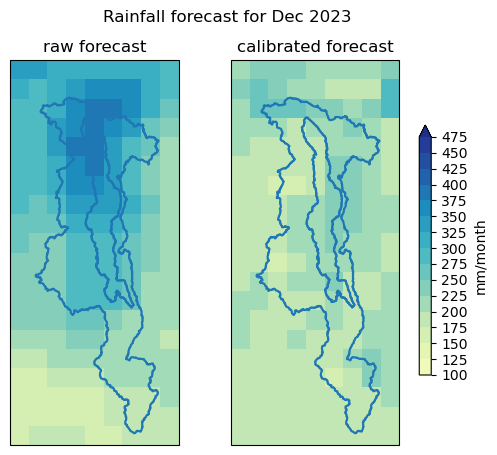

In [45]:
#plotting median of the forecast for the selected (monthly) time step

#selected time step. You can change this value. But since the forecast data has only 6 steps, 
# and time step value is indexed from 0, the maximum value allowed is 5

leadtime=3

#finding date for which forecast will be plotted
date2plot=pd.to_datetime("{}-{}-01".format(fcstyear,str(fcstmonth).zfill(2)))+pd.offsets.DateOffset(months=leadtime)
date2plot=date2plot.strftime("%b %Y")

#setting up plot parameters - these might need to be adjusted by hand
#minimum and maximum value
vmin=100
vmax=500
#step of the legend
vstep=25
#vstep=vmax/10


#categorical  levels for colorbar
cbar_levels=np.arange(vmin,vmax,vstep)
#color map
cmap = plt.get_cmap('YlGnBu')
#colors for legend levels
cbar_colors = cmap(np.linspace(0.1, 0.9, len(cbar_levels)))
#whether or not to extend the legend
extend="max"
#generating color map
cmap, norm = colors.from_levels_and_colors(cbar_levels, cbar_colors, extend=extend)
#label for legend
cbar_label="mm/month"

#reading basin polygon to overplot on the gridded map
basin_poly=gpd.read_file(basin_shapefile)

#instatiating figure
fig=plt.figure(figsize=(6,5))
#generating subplot
pl=fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
#preparing data to plot - selecting time step, and calculating median across all members 
data2plotraw=fcstmon_current[leadtime,:,:].median("member")
#plotting...
m=data2plotraw.plot(ax=pl,cmap=cmap, add_colorbar=False,norm=norm)
#overplotting basin boundary
basin_poly.boundary.plot(ax=pl)
#title of the subplot
pl.set_title("raw forecast")

#instantiating next subplot
pl=fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())
#selecting data for plot
data2plotcalib=fcstmoncalib_current[leadtime,:,:].median("member")
#plotting
m=data2plotcalib.plot(ax=pl, cmap=cmap, add_colorbar=False, norm=norm)
#overplotting basin boundary
basin_poly.boundary.plot(ax=pl)
#subplot title
pl.set_title("calibrated forecast")
#creating axis for colorbar
pl=fig.add_axes([0.82,0.25,0.02,0.5])
#plotting colorbar
cbar = fig.colorbar(m, cax=pl,ticks=cbar_levels, label=cbar_label, extend=extend)
#housekeeping
plt.subplots_adjust(right=0.8)
plt.suptitle("Rainfall forecast for {}".format(date2plot))
plt.show()

Now, let's plot time series of raw and calibrated monthly forecast for a single point

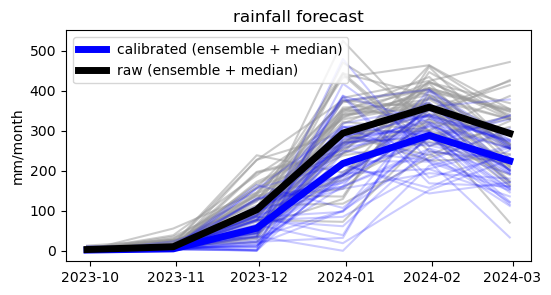

In [24]:
#coordinates of a point within the domain
lat,lon=-13,34

#instatiating figure
fig=plt.figure(figsize=(6,3))
#generating subplot
pl=fig.add_subplot(1,1,1)

#preparing data for raw forecast
data2plotraw=fcstmon_current.sel(latitude=lat,longitude=lon, method="nearest")
data2plotraw=data2plotraw.drop_vars(["latitude","longitude"]).to_pandas()
#plotting all ensemble members
pl.plot(data2plotraw, color="0.6", alpha=0.5)

#preparing data for calibrated forecast
data2plotcalib=fcstmoncalib_current.sel(latitude=lat,longitude=lon, method="nearest")
data2plotcalib=data2plotcalib.drop_vars(["latitude","longitude"]).to_pandas()

#plotting calibrated forecast
pl.plot(data2plotcalib, color="blue", alpha=0.2)

#plotting ensemble medians
pl.plot(data2plotcalib.index, np.median(data2plotcalib,1), color="blue", lw=5, label="calibrated (ensemble + median)")
pl.plot(data2plotraw.index, np.median(data2plotraw,1), color="black", lw=5, label="raw (ensemble + median)")
#housekeeping
pl.set_title("rainfall forecast")
pl.set_ylabel("mm/month")
plt.legend()
plt.show()

In [27]:
#this is user-defined
leadtime=3
#this too. note that there are no checks if these values are within bounds. If not - the code will crash.
lat,lon=-13,34

#finding date for which forecast will be evaluated

#this will be calendar month of the target month at current lead time 
calendarmon=fcstmon.time[leadtime].dt.month.data
print(calendarmon)
fcstmonth_abbr=calendar.month_abbr[calendarmon]

# selecting data for the target month only
refmonselected=refmon.sel(time=refmon.time.dt.month==calendarmon).sel(latitude=lat,longitude=lon, method="nearest")
fcstmonselected=fcstmon.sel(time=fcstmon.time.dt.month==calendarmon).sel(latitude=lat,longitude=lon, method="nearest")
fcstmoncalibselected=fcstmoncalib.sel(time=fcstmon.time.dt.month==calendarmon).sel(latitude=lat,longitude=lon, method="nearest")

#deriving dates when forecast and observations overlap - that will be our climatological period
# we could potentially further constrain it to fall within a range of years, but in the data analysed here, 
# the overlap is relatively short 1982-2013, so we can consider this entire period to be "climatologial period"
ovlpdates=[x for x in fcstmonselected.time.data if (x in refmonselected.time.data) and (x in fcstmonselected.time.data)]

#selecting raw forecast data within the climatology period
sel=fcstmonselected.time.isin(ovlpdates)
fcstmonovlp=fcstmonselected.sel(time=sel)

#selecting observational reference data within the climatology period
sel=refmonselected.time.isin(ovlpdates)
refmonovlp=refmonselected.sel(time=sel)

#selecting calibrated forecast data within the climatology period
sel=fcstmoncalibselected.time.isin(ovlpdates)
fcstmoncalibovlp=fcstmoncalibselected.sel(time=sel)

12


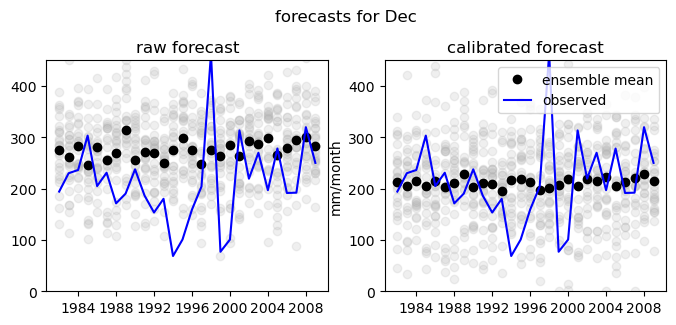

In [28]:
#plotting forecast
ymin,ymax=0,450
fig=plt.figure(figsize=(8,3))
#generating subplot

pl=fig.add_subplot(1,2,1)

pl.plot(fcstmonovlp.time, fcstmonovlp, "o", color="0.7", alpha=0.2)
pl.plot(fcstmonovlp.time, fcstmonovlp.mean("member"), "o", color="0")
pl.plot(refmonovlp.time, refmonovlp, color="blue", label="observed")

pl.set_ylim(ymin,ymax)
pl.set_title("raw forecast")

pl=fig.add_subplot(1,2,2)

pl.plot(fcstmoncalibovlp.time, fcstmoncalibovlp, "o", color="0.7", alpha=0.2)
pl.plot(fcstmoncalibovlp.time, fcstmoncalibovlp.mean("member"), "o", color="0", label="ensemble mean")
pl.plot(refmonovlp.time, refmonovlp, color="blue", label="observed")
pl.set_ylim(ymin,ymax)
pl.set_title("calibrated forecast")

plt.suptitle("forecasts for {}".format(fcstmonth_abbr), y=1.05)
pl.set_ylabel("mm/month")
plt.legend()
plt.show()

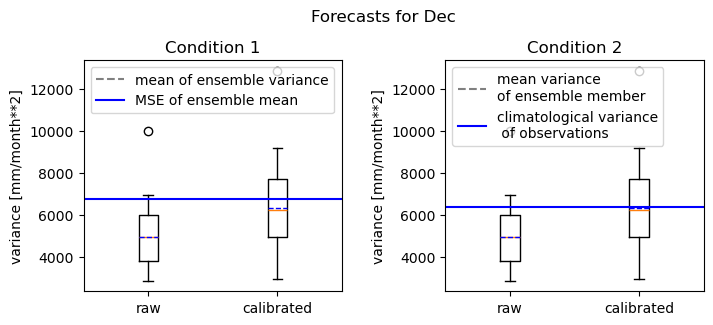

In [29]:
import matplotlib.lines as mlines
mean_line = mlines.Line2D([], [], color='grey', linestyle="--")
other_line = mlines.Line2D([], [], color='blue', linestyle="-")

#plotting variances
fig=plt.figure(figsize=(8,3))
#generating subplot

pl=fig.add_subplot(1,2,1)

#condition 1
mse=np.mean((fcstmoncalibovlp.mean("member")-refmonovlp)**2)
membervarcalib=fcstmoncalibovlp.var("member")
membervar=fcstmonovlp.var("member")

pl.boxplot([membervar,membervarcalib], showmeans=True, meanline=True, meanprops={"color":"blue"})
pl.axhline(mse, label="MSE of ensemble mean", color="blue")

#pl.plot(fcstmoncalibovlp.time, fcstmoncalibovlp.mean("member"), "o", color="0")
pl.set_title("Condition 1")
pl.set_ylabel("variance [mm/month**2]")
pl.set_xticklabels(["raw","calibrated"])
#plt.legend(loc="upper left")
plt.legend(handles=[mean_line,other_line],labels=["mean of ensemble variance","MSE of ensemble mean"],loc="upper left")


pl=fig.add_subplot(1,2,2)

membervarcalib=(fcstmoncalibovlp-fcstmoncalibovlp.mean()).var("member")
membervar=(fcstmonovlp-fcstmonovlp.mean()).var("member")

pl.boxplot([membervar,membervarcalib], showmeans=True, meanline=True, meanprops={"color":"blue"})

pl.axhline(refmonovlp.var(),label="climatological variance\n of observations", color="blue")

pl.set_ylabel("variance [mm/month**2]")
pl.set_xticklabels(["raw","calibrated"])
plt.legend(handles=[mean_line,other_line],labels=["mean variance \nof ensemble member","climatological variance\n of observations"],loc="upper left")
pl.set_title("Condition 2")

plt.suptitle("Forecasts for {}".format(fcstmonth_abbr), y=1.05)

plt.subplots_adjust(wspace=0.4)
plt.show()

# Bias-correcting daily data

Now that we have downscaled and calibrated data at monthly time scale, we can proceed with aligning daily data so that its monthly total aligns with calibrated monthly data.


## Methodology

The approach to bias correct daily data is based on quantile-quantile (q-q) mapping.In its basic implementation, q-q mapping is realtively simple and involves the following steps:
- derivation of empirical distribution function for observed data over a reference period
- derivation of empirical distribution funcion for model data over the reference period
- for each (model) data point that is being bias corrected:
    - finding its quantile in the model pdf
    - finding a corresponding value for that quantile in the observed pdf
    - assigning that value as the bias-corrected value for given data point
In the implementation presented here, that basic procedure undergoes two main alterations:
1) additional process is introduced to enable a correct representation of the ratio of rain days to dry days. This is becuase the simple procedure described above does not explicitly take that ration into consideration, and consequently the number of rain and dry days in the bias-corrected data is inherited from that in the model data. If a model has a strong bias in that characteristic, this bias is not "fixed" by the simple implementation of the q-q method. 
In order to ensure correct representation of dry/wet day ratio, the following procedure is implemented:
- before fitting pdfs to observational and model data, zeros in both datasets (actually values below a certain threshold, say 1mm/day) are replaced by small random numbers.
- pdfs are fitted to such amended data
- quantile-quantile transformation is implemented
- upon completion, all values in the bias-corrected time series that fall below the set threshold are converted to 0. 
Since the observed series that is the basis of pdf fitting does not contain any 0 values, but rather contains a set of small values that form the tail of the fitted distribution, the resulting distribution of bias-corrected data contains similar tail. Converting those tail values to 0 ensures the correct rain day/dry day ratio.
This procedure is able to correct model data that have too many rain days compared to observations, but also model data that have too few rain days. It is important to note, however, that this procedure does not account for the sequencing of dry and wet days. That, is in the bias-corrected data inherited from the model data. In case model data have too many rain days, the days with lowest rainfall values will be converted to dry days. In case model data have too few rain days, those will be added in random location. 

2) bias correction as described above ensures the agreement between distribution of bias-corrected model data and observed data. But it does not transform the daily model data in the same way as calibration of monthly data does. As a result, the monthly total of the bias-corrected daily data does not correspond to the calibrated monthly value. In order to achive that correspondence, we introduce an iterative procedure.

In that procedure, illustrated in Fig. 5, quantiles that are used to find the value in the observed pdf are not those that are derived for model data from the model pdf. Rather, they are adjusted by modifying them by a "correction factor". That factor is iteratively adjusted until the total of daily rainfall values within a given month is equal to the calibrated monthly value for that month. 


## Implementation

Bias-correction of daily data is achieved by applying a bespoke bias-correction function over each grid point, separately for each month (lead time) of the forecast. This function implements the process described above and illustrated in Fig. 5. 

In [68]:
def qqm_monadjust(_fcstref,_obsref,_fcstday,_fcstmon,_convcrit,_maxiter):
    #making sure reference period does not have nans
    _fref=_fcstref[~np.isnan(_fcstref)]
    
    #fitting ecdf to data in reference period
    ecdf = ECDF(_fref.flatten())
    
    #preparing array to store the output
    #copying array with non-bias-corrected data to have output array of exactly the same dimensions
    _fcstdaybc=_fcstday.copy()
    #filling that array with nans
    _fcstdaybc[:]=np.nan

    #iterating through members of the forecast ensemble
    for m in range(_fcstday.shape[1]):
        #extracting data for current member
        _mfcstday=_fcstday[:,m]
        _mfcstmon=_fcstmon[:,m]
        
        #deriving quantiles for daily forecast data
        _mfcstday_quant=ecdf(_mfcstday.flatten())
        
        # finding rainfall values in observations that corresponds to given quantiles
        # this a temporary value that will be further adjusted through iterative process 
        _mfcstdaybc=np.nanquantile(_obsref.flatten(), _mfcstday_quant)
        
        # calculating correction factor, i.e. ratio of monthly total to sum of daily values
        # this is temporary value that will be adjusted through iterative process
        _corfacmon=_mfcstmon/_mfcstdaybc.sum() #this is in terms of rainfall values
        
        # for stability of iterations, i.e. to avoid divergence of the iterative process, 
        # we set up minimum and maximum possible value of correction factor
        _quantcorfac_min,_quantcorfac_max=0.01,4
        
        #this is to ensure faster convergence of iterations by constraining ranges as 
        # determined by calibrated monthly total and current total of daily data
        if _corfacmon>1:
            _quantcorfac_min=1
            _quantcorfac=_quantcorfac_min
        else:
            _quantcorfac_max=1
            _quantcorfac=_quantcorfac_max
            
        
        #this is a special case when calibrated monthly total is small. Daily data are reset to 0 then.
        if _mfcstmon<tracemon:
            _corfacmon=1
            _mfcstdaybc=_mfcstday.copy()
            _mfcstdaybc[:]=0
            
        # implementing iterative adjustement until convergence criterion is reached
        i=0
        while np.abs(_corfacmon-1)>_convcrit:
            i+=1
            #calculating adjusted quantiles
            _quant_adj=_mfcstday_quant*_quantcorfac
            
            #making sure adjusted quantiles are realistic
            _quant_adj[_quant_adj>1]=1
            
            # calculating rainfall values for the adjusted quantiles
            _mfcstdaybc=np.nanquantile(_obsref.flatten(), _quant_adj)
            
            # calculating adjustment needed for actual rainfall values
            _corfacmon=_mfcstmon/_mfcstdaybc.sum()
            
            if _corfacmon>1:
                # if corfacmon>1 then monthly total is too small, and daily values need to go up, 
                # for this we raise minimum possible value of quantile correcton factor
                _quantcorfac_min=_quantcorfac
            else:
                #if corfacmon<1 then monthly total is too large, and daily values need to go down 
                # for this we reduce maximum possible value of quantile correction factor
                _quantcorfac_max=_quantcorfac
                
            _quantcorfac=(_quantcorfac_min+_quantcorfac_max)/2
            
            if i==_maxiter:
                print("maxiter reached\ntarget monthly total:{}, current daily total:{}, original daily total:{}".format(_mfcstmon,_mfcstdaybc.sum(),_mfcstday.sum()))
                break
        
        _fcstdaybc[:,m]=_mfcstdaybc
    return _fcstdaybc.reshape(*_fcstday.shape)

We need to prepare data for distribution fitting

In [69]:
print("reading monthly reference data from: {}".format(referencemon_file))
referencedayds=xr.open_dataset(referenceday_file)
refday=referencedayds[variable]

print("opening all daily files for given month ({})".format(fcstmonth))
fcstday=xr.open_mfdataset(harmonizedfcstday_files).load()[variable]

print("opening monthly calibrated forecast for given month ({})".format(fcstmonth))
fcstmon=xr.open_dataset(calibratedfcstmon_file).load()[variable]


reading monthly reference data from: data/observed-reference/mon/malawi/pr/pr_mon_DCCMS_197001-201312.nc
opening all daily files for given month (9)
opening monthly calibrated forecast for given month (9)


and here we implement the procedure to each lead time

In [70]:
print("bias correcting...")

fcstdaybc=[]
for leadtime in range(6):
    print("leadtime: {}".format(leadtime))
    
    targetdate=pd.to_datetime(fcstmon.time[leadtime].data)
    targetmon=fcstmon.time[leadtime].dt.month.data
    
    
#    print(calendarmon)
    # selecting data for the target month only
    refdayselected=refday.sel(time=refday.time.dt.month==targetmon)
    fcstdayselected=fcstday.sel(time=fcstday.time.dt.month==targetmon)
        
    # finding dates in reference data for which reforecast is available
    overlap=[x for x in refdayselected.time.data if x in fcstdayselected.time.data]
    
    #this will have the same dimensions as fcstselected, and will be filled with reference data, when available, otherwise nan
    refdayoverlap=refdayselected.sel(time=overlap)
        
    #selecting overlap of obs and forecast
    overlap=[x for x in fcstdayselected.time.data if x in refdayselected.time.data]
    fcstdayoverlap=fcstdayselected.sel(time=overlap)

    #selecting daily and monthly data for target forecast, i.e. forecast issued on the target month
    fcstdaytarget=fcstday.sel(time=targetdate.strftime("%Y-%b"))
    fcstmontarget=fcstmon.sel(time=targetdate.strftime("%Y-%b"))
        
    #replacing values less than trace with random numbers. This is done in order to allow adjustement of the number of rain days.
    rdata=np.copy(refdayoverlap)
    rdata[:]=np.random.uniform(traceday/10,traceday,len(rdata.flatten())).reshape(*rdata.shape)
    refdayoverlap=refdayoverlap.where((refdayoverlap<traceday)==False, rdata)
    del rdata
    
    #the same in model data over the reference period
    rdata=np.copy(fcstdayoverlap)
    rdata[:]=np.random.uniform(traceday/10,traceday,len(rdata.flatten())).reshape(*rdata.shape)
    fcstdayoverlap=fcstdayoverlap.where((fcstdayoverlap<traceday)==False, rdata)
    del rdata
    
    # the same in model data for target forecast
    rdata=np.copy(fcstdaytarget)
    rdata[:]=np.random.uniform(traceday/10,traceday,len(rdata.flatten())).reshape(*rdata.shape)
    fcstdaytgt=fcstdaytarget.where((fcstdaytarget<traceday)==False, rdata)
    del rdata
#    print(fcstdaytgt.time)
    #applying the bias-correction/adjustment function
    temp=xr.apply_ufunc(
        qqm_monadjust, 
        fcstdayoverlap.load(),
        refdayoverlap,
        fcstdaytgt.load().rename({"time":"time1"}),
        fcstmontarget.rename({"time":"time2"}),
        convcrit,
        maxiter,
        input_core_dims=[["time","member"],["time"],["time1","member"],["time2","member"],[],[]],
        vectorize=True,
        output_core_dims=[["time1","member"]]
    )
    #housekeeping after apply_ufunc
    fcstdaytargetbc=temp.rename({"time1":"time"}).transpose("time","member","latitude","longitude")
    #appending data for given lead time to the final stash of bias-corrected and calibrated data
    fcstdaybc.append(fcstdaytargetbc)

bias correcting...
leadtime: 0
leadtime: 1
leadtime: 2
maxiter reached
target monthly total:[194.17154], current daily total:191.83076840848014, original daily total:250.78704833984375
maxiter reached
target monthly total:[8.265831], current daily total:8.549407119809704, original daily total:5.575596332550049
maxiter reached
target monthly total:[5.0780716], current daily total:5.319215542817492, original daily total:18.553468704223633
maxiter reached
target monthly total:[5.2781754], current daily total:5.8776854405742665, original daily total:22.944889068603516
leadtime: 3
maxiter reached
target monthly total:[8.907974], current daily total:12.27692667158719, original daily total:62.633766174316406
maxiter reached
target monthly total:[13.385757], current daily total:13.811727310450866, original daily total:58.39358139038086
maxiter reached
target monthly total:[12.687042], current daily total:20.37809691103969, original daily total:94.62408447265625
maxiter reached
target monthly t

maxiter reached
target monthly total:[24.052628], current daily total:26.210040259660268, original daily total:27.584232330322266
maxiter reached
target monthly total:[33.364075], current daily total:33.886476341945034, original daily total:70.30286407470703
maxiter reached
target monthly total:[42.58876], current daily total:45.08880604682348, original daily total:248.67779541015625


Now a few operations to finalize the process

In [71]:
# Concatenating outputs from individual lead times (so far stored in a list) into a single data array
fcstdaycalib=xr.concat(fcstdaybc, dim="time")
# making sure there is a correct sequencing of dates
fcstdaycalib=fcstdaycalib.sortby("time")
# Since we are processing rainfall - negative values are not realistic, although they may emerge from the IoV calibration process
# this makes sure negative values are not retained in the calibrated monthly data
fcstdaycalibnoneg=fcstdaycalib.where(fcstdaycalib>0,0)
fcstdaycalib=fcstdaycalibnoneg.where(~np.isnan(fcstdaycalib))

### Finishing off the daily process

In [72]:
# this just rounds the values to 2 decimal digits
fcstdaycalib=np.round(fcstdaycalib,2)

#Checking for unrealistic daily values
#note that the code does not halt if there are high values. 
#You have to decide if the values are acceptable. If not - then perhaps there is someghing wrong with the data (or the code?)
maxval=np.max(fcstdaycalib.data)
print("daily maximum {}".format(maxval))

if maxval>350:
    print("unrealistic max {}".format(maxval))

#saving the selected data to output file
fcstdaycalib.to_netcdf(calibratedfcstday_file)
print("written {}".format(calibratedfcstday_file))



daily maximum 109.5
written data/forecast-calibrated/ECMWF/SEAS51/day/malawi/pr/pr_day_ECMWF_SEAS51_fcst-iov_202309.nc


## Daily data diagnostics

- monthly calibrated and monthly bias-corrected/adjusted
- daily cdf in raw data, in bias-corrected data, in observed data

plotting day: 2024-02-26 and month: 2024-02
382.00006


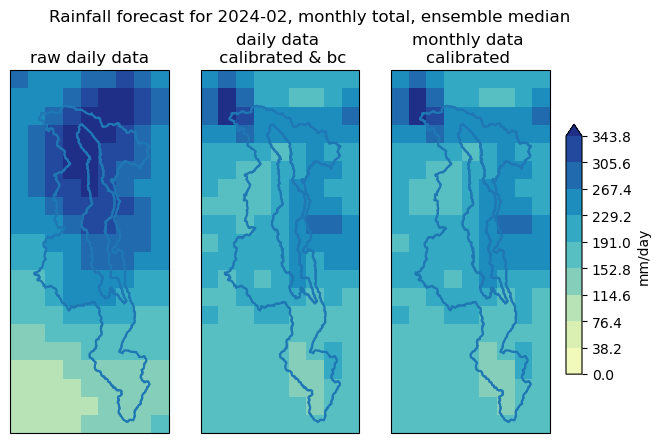

In [77]:
#plotting median of the forecast for the selected (monthly) time step

#selected time step.Since the forecast data has only 6 steps, the maximum value allowed is 5
leadtime=5
day=26

#finding date for which forecast will be plotted
day2plot=(pd.to_datetime("{}-{}".format(fcstyear,str(fcstmonth).zfill(2)))+pd.offsets.DateOffset(months=leadtime)+pd.offsets.DateOffset(day=day)).strftime("%Y-%m-%d")
mon2plot=(pd.to_datetime("{}-{}".format(fcstyear,str(fcstmonth).zfill(2)))+pd.offsets.DateOffset(months=leadtime)+pd.offsets.DateOffset(day=day)).strftime("%Y-%m")
print("plotting day: {} and month: {}".format(day2plot, mon2plot))


#calculating ensemble medians of:
#calibrated daily data
data2plotcalib=fcstdaycalib.sel(time=mon2plot).sum("time").median("member")
#raw daily data
data2plotraw=fcstday.sel(time=mon2plot).sum("time").median("member")
#calibrated monthly data
data2plotmoncalib=fcstmoncalib_current.sel(time=mon2plot).median("member")


#setting up plot parameters

#minimum and maximum values - one may need to adjust them by hand
vmin=0
vmax=np.max([np.max(data2plotcalib), np.max(data2plotraw)])
print(vmax)
#vmax=300
#step of the legend
vstep=vmax/10

#categorical  levels for colorbar
cbar_levels=np.arange(vmin,vmax,vstep)
#color map
cmap = plt.get_cmap('YlGnBu')
#colors for legend levels
cbar_colors = cmap(np.linspace(0.1, 0.9, len(cbar_levels)))
#whether or not to extend the legend
extend="max"
#generating color map
cmap, norm = colors.from_levels_and_colors(cbar_levels, cbar_colors, extend=extend)
#label for legend
cbar_label="mm/day"

#reading basin polygon to overplot on the gridded map
basin_poly=gpd.read_file(basin_shapefile)



#instatiating figure
fig=plt.figure(figsize=(8,5))
#generating subplot
pl=fig.add_subplot(1,3,1, projection=ccrs.PlateCarree())
#preparing data to plot - selecting time step, and calculating median across all members 
#plotting...
m=data2plotraw.plot(ax=pl,cmap=cmap, add_colorbar=False, norm=norm)
#overplotting basin boundary
basin_poly.boundary.plot(ax=pl)
#title of the subplot
pl.set_title("raw daily data")

#instantiating next subplot
pl=fig.add_subplot(1,3,2, projection=ccrs.PlateCarree())
#selecting data for plot
#plotting
m=data2plotcalib.plot(ax=pl, cmap=cmap, add_colorbar=False, norm=norm)
#overplotting basin boundary
basin_poly.boundary.plot(ax=pl)
#subplot title
pl.set_title("daily data \n calibrated & bc")

#instantiating next subplot
pl=fig.add_subplot(1,3,3, projection=ccrs.PlateCarree())
#selecting data for plot
#plotting
m=data2plotmoncalib.plot(ax=pl, cmap=cmap, add_colorbar=False, norm=norm)
#overplotting basin boundary
basin_poly.boundary.plot(ax=pl)
#subplot title
pl.set_title("monthly data \ncalibrated ")


#creating axis for colorbar
pl=fig.add_axes([0.82,0.25,0.02,0.5])
#plotting colorbar
cbar = fig.colorbar(m, cax=pl,ticks=cbar_levels, label=cbar_label, extend=extend)
#housekeeping
plt.subplots_adjust(right=0.8)
plt.suptitle("Rainfall forecast for {}, monthly total, ensemble median".format(mon2plot))
plt.show()

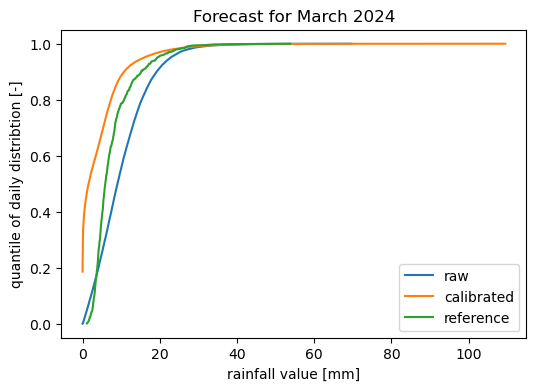

In [82]:
#plotting daily distributions

leadtime=5
lat,lon=-13,34

#finding date for which forecast will be evaluated

#this will be calendar month of the target month at current lead time 
calendarmon=fcstmon.time[leadtime].dt.month.data
fcstmonth_abbr=calendar.month_abbr[calendarmon]

# selecting data for the target month only
refdayselected=refday.sel(time=refday.time.dt.month==calendarmon).sel(latitude=lat,longitude=lon, method="nearest")
fcstdayselected=fcstday.sel(time=fcstday.time.dt.month==calendarmon).sel(latitude=lat,longitude=lon, method="nearest")
fcstdaycalibselected=fcstdaycalib.sel(time=fcstdaycalib.time.dt.month==calendarmon).sel(latitude=lat,longitude=lon, method="nearest")

#deriving dates when forecast and observations overlap - that will be our climatological period
# we could potentially further constrain it to fall within a range of years, but in the data analysed here, 
# the overlap is relatively short 1982-2013, so we can consider this entire period to be "climatologial period"
ovlpdates=[x for x in fcstdayselected.time.data if (x in refdayselected.time.data) and (x in fcstdayselected.time.data)]

#selecting raw forecast data within the climatology period
sel=fcstdayselected.time.isin(ovlpdates)
fcstdayovlp=fcstdayselected.sel(time=sel)

#selecting observational reference data within the climatology period
sel=refdayselected.time.isin(ovlpdates)
refdayovlp=refdayselected.sel(time=sel)

#selecting calibrated forecast data within the climatology period
sel=fcstdaycalibselected.time.isin(ovlpdates)
fcstdaycalibovlp=fcstdaycalibselected.sel(time=sel)


#instatiating figure
fig=plt.figure(figsize=(6,4))
#generating subplot
pl=fig.add_subplot(1,1,1)

dataraw=np.sort(fcstdayovlp.data.flatten())
dataraw=dataraw[~np.isnan(dataraw)]
ecdfraw = ECDF(dataraw)
quantraw=ecdfraw(dataraw)
pl.plot(dataraw, quantraw, label="raw")

datacalib=np.sort(fcstdaycalib.data.flatten())
ecdfcalib = ECDF(datacalib)
quantcalib=ecdfcalib(datacalib)
pl.plot(datacalib, quantcalib, label="calibrated")

dataref=np.sort(refdayovlp.data.flatten())
ecdfref = ECDF(dataref)
quantref=ecdfref(dataref)
pl.plot(dataref, quantref, label="reference")
plt.legend()
pl.set_xlabel("rainfall value [mm]")
pl.set_ylabel("quantile of daily distribtion [-]")
pl.set_title("Forecast for March 2024")
plt.show()